### **Lab 04 - The Transformer Model for Language Translation**

Welcome to our lab on the Transformer model, a revolutionary architecture in deep learning that has transformed the field of natural language processing (NLP) and beyond.

The **Transformer**, introduced in 2017 by Vaswani et al. in their paper "Attention is All You Need", represents a significant departure from previous sequence processing models. Unlike recurrent neural networks (RNNs) or long short-term memory (LSTM) networks, Transformers rely entirely on an attention mechanism to draw global dependencies between input and output.
Key Features of Transformers

**Attention Mechanism:** At the heart of the Transformer is the self-attention mechanism, which allows the model to weigh the importance of different parts of the input when processing each element.

**Parallelization:** Transformers can process entire sequences in parallel, dramatically reducing training time compared to sequential models like RNNs.
Scalability: The architecture scales effectively to handle large amounts of data and long sequences.

In this lab, we'll dive into the Transformer's architecture, exploring its components such as multi-head attention, positional encoding, and feed-forward networks. We'll also discuss how Transformers have become the foundation for state-of-the-art models like BERT and GPT, revolutionizing tasks from machine translation to text generation.

We will work on the task of **Language Translation** and learn to train the transformer model to translate English into Swedish. By the end of this session, you'll have a solid understanding of how Transformers work and why they've become so crucial in modern deep learning applications. Let's begin our journey into this fascinating model!

**The Transformer Model**

Image from the original paper "Attention is All by You Need" Vaswani et.

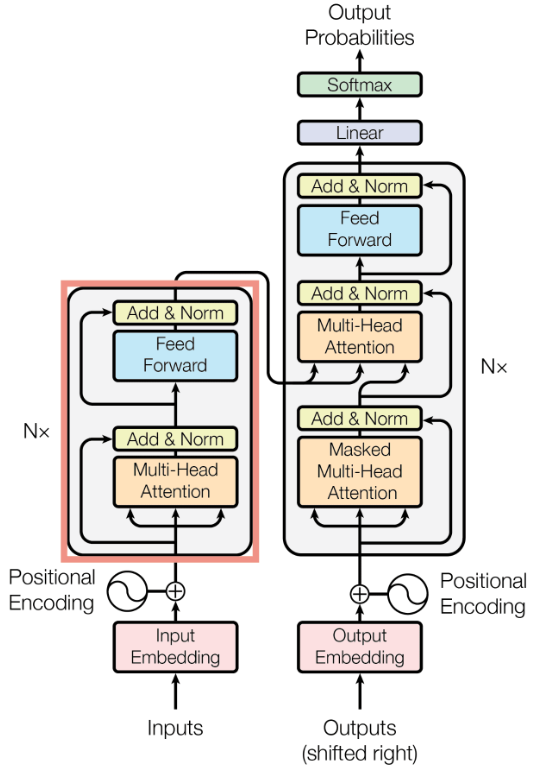

# A high Level Look

Let's start by viewing the model as a single black box. In the context of a machine translation application, it takes a sentence in one language as input and produces its translation in another language as output.

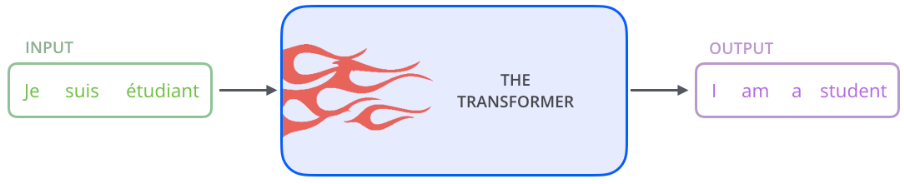

(Image Source: https://jalammar.github.io/illustrated-transformer/)

When we examine the inner workings of the Transformer model, we find an architecture with distinct encoding and decoding components, along with connections between them. This structure is designed to efficiently process and generate sequential data.

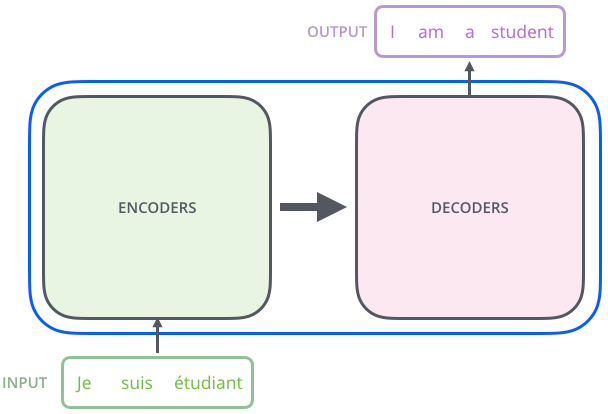

Image Source: https://jalammar.github.io/illustrated-transformer/)

The encoding component consists of a stack of identical encoder layers (typically 6 in the original Transformer model) and the decoder contains a stack of the same number of decoder layers as shown below:

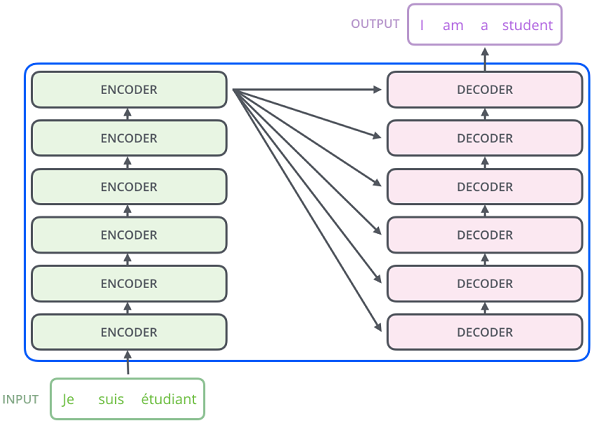

Image Source: https://jalammar.github.io/illustrated-transformer/)

Let's break it down:

**Encoding Component**

Each encoder layer contains:

*   **Self-Attention Mechanism:** This allows the model to weigh the importance of different parts of the input sequence when processing each element.
*   **Feed-Forward Neural Network:** Applied to each position separately and identically, further processing the information from the self-attention layer.


**Decoding Component**

The decoding component mirrors the encoding component with a stack of identical decoder layers. Each decoder layer includes:

* **Masked Self-Attention Mechanism:** Similar to the encoder's self-attention, but prevents positions from attending to subsequent positions in the sequence.

* **Encoder-Decoder Attention:** This layer allows the decoder to focus on relevant parts of the input sequence. It uses queries from the previous decoder layer, and keys and values from the encoder output.

* **Feed-Forward Neural Network:** Similar to the encoder's feed-forward layer.

**Connections Between Components**

The key connection between the encoding and decoding components is the encoder-decoder attention layer in the decoder. This layer:
1. Takes the output from the encoder as keys and values.
2. Uses the previous decoder layer's output as queries.

In [2]:
!pip install datasets torchmetrics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 27.7 MB/s eta 0:00:00


In [3]:
import torch
import torch.nn as nn
import math
from torch.utils.data import Dataset
#import torchtext.datasets as datasets
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim.lr_scheduler import LambdaLR

import warnings
from tqdm import tqdm
import os
from pathlib import Path

# Huggingface datasets and tokenizers
from datasets import load_dataset
from tokenizers import Tokenizer
from tokenizers.models import WordLevel
from tokenizers.trainers import WordLevelTrainer
from tokenizers.pre_tokenizers import Whitespace

import torchmetrics
from torch.utils.tensorboard import SummaryWriter

# Breaking down the Transformer:

We will go through each part of the transformer model. First of all we are going to see how we manage the conversion of text tokens to embeddings so that we can feed the words into the encoder (as well as the decoder) of the transformer. So we will look at the 'Input Embeddings' and the 'Positional Encoding' parts of the transformer highlighted in the image below.

### Input Embeddings

The `InputEmbeddings` class is responsible for converting input token indices into dense vectors that represent those tokens in a high-dimensional space. This is a crucial first step in the Transformer architecture, as it transforms discrete token representations into a format suitable for processing by the model.


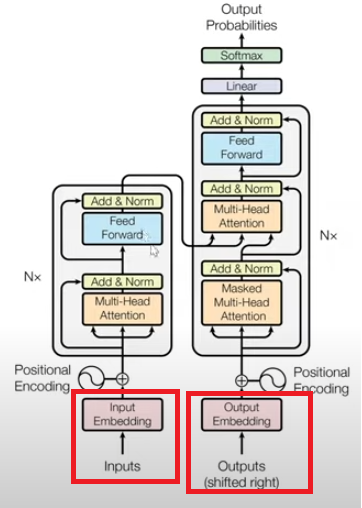

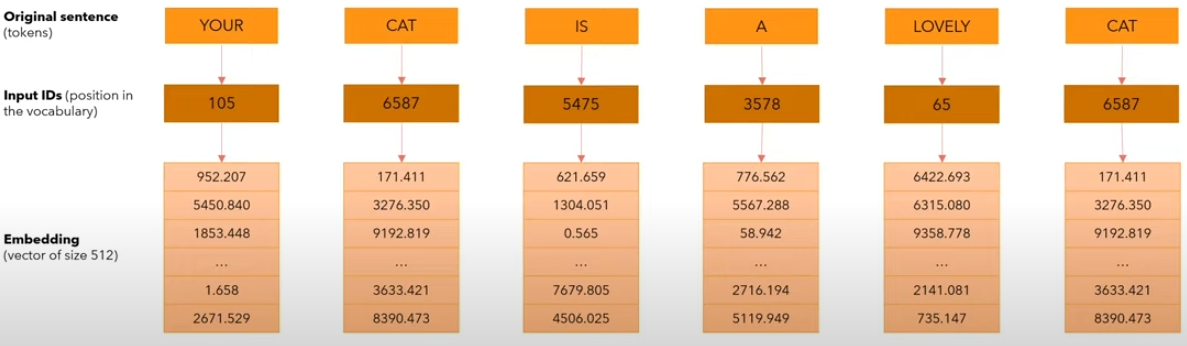

### Task 1:

Complete the line of code in the cell below. We are creating an InputEmbedding class so that we can use it to convert our token vector of size `vocab_size` into a word embedding of size `d_model` and for that we need to initialize the `nn.Embedding` layer. This function takes two arguments, the `vocab_size` and the `d_model`. Complete the line of code below to create the embedding layer as instructed.

Once the embedding layer is defined, apply it on the input `x` in the forward function and multiply it with the square root of `d_model`. You can use the math.sqrt() function to do this. Finally return the result.

In [4]:
class InputEmbeddings(nn.Module):

    def __init__(self, d_model: int, vocab_size: int) -> None:
        super().__init__()
        self.d_model = d_model
        self.vocab_size = vocab_size
        ### CODE START HERE ###
        self.embedding = nn.Embedding(d_model, vocab_size) # Use the nn.Embedding function here, use vocab_size and d_model as arguments
        ### END CODE HERE ###

    def forward(self, x):
        # (batch, seq_len) --> (batch, seq_len, d_model)
        # Multiply by sqrt(d_model) to scale the embeddings according to the paper

        ### CODE START HERE ###
        x = self.embidding(x)        # apply the self.embedding layer
        x = x * math.sqrt(self.d_model)          # multiply output of embedding layer with square root of d_model
        ### END CODE HERE ###

        return x

#### Code Breakdown

1. **Initialization (`__init__` method)**:
   - **Parameters**:
     - `d_model`: The dimensionality of the output embedding vectors. This is typically the size of the hidden layers in the Transformer.
     - `vocab_size`: The size of the vocabulary, which determines how many unique tokens can be embedded.
   - **Embedding Layer**:
     - `self.embedding`: This creates an embedding layer that maps each token in the vocabulary to a dense vector of size `d_model`.

2. **Forward Method**:
   - The `forward` method takes an input tensor `x`, which contains the token indices (with shape `(batch, seq_len)`).
   - It outputs the corresponding embeddings with shape `(batch, seq_len, d_model)`.
   - **Scaling**:
     - The embeddings are scaled by multiplying them by sqrt(self.d_model). This scaling helps stabilize gradients during training, as discussed in the original Transformer paper ("Attention is All You Need"). It ensures that the magnitude of the embeddings is appropriate for the subsequent layers.

#### Key Points
- Input embeddings are essential for converting categorical data (token indices) into a continuous representation.
- The scaling factor is an important detail that contributes to the model's performance.
- This class can be easily extended or modified to include positional encodings, which are also necessary for providing the model with information about the order of tokens in a sequence.

==================================================================

### Positional Encoding

The `PositionalEncoding` class adds information about the position of each token in the sequence, which is essential for the Transformer model since it does not have any inherent notion of token order. This class generates positional encodings based on sine and cosine functions, allowing the model to capture positional information effectively.



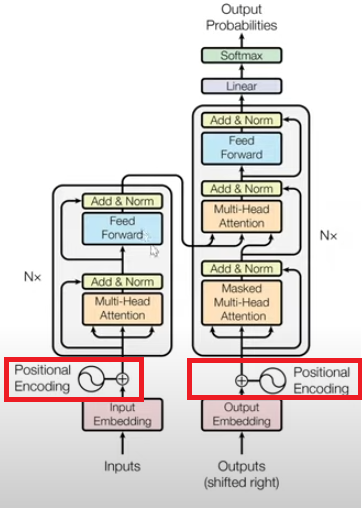

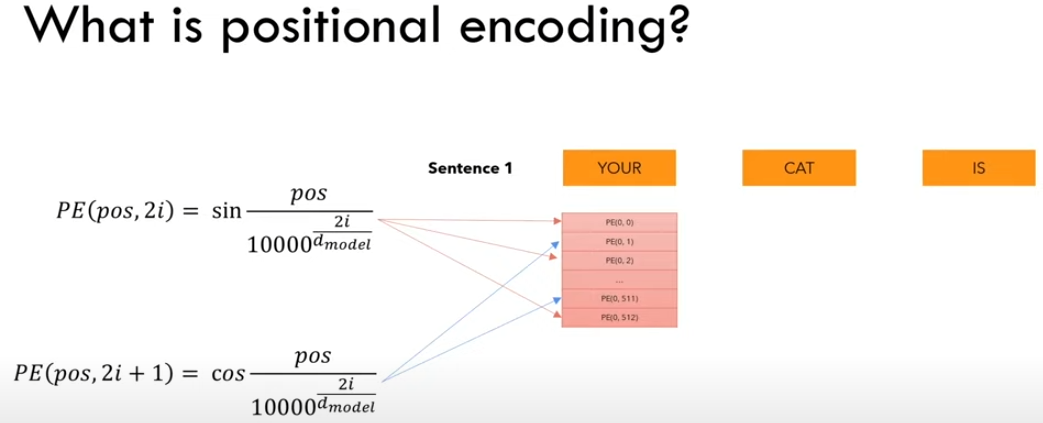

In [5]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, seq_len: int, dropout: float) -> None:
        super().__init__()
        self.d_model = d_model
        self.seq_len = seq_len
        self.dropout = nn.Dropout(dropout)
        # Create a matrix of shape (seq_len, d_model)
        pe = torch.zeros(seq_len, d_model)
        # Create a vector of shape (seq_len)
        position = torch.arange(0, seq_len, dtype=torch.float).unsqueeze(1) # (seq_len, 1)
        # Create a vector of shape (d_model)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model)) # (d_model / 2)
        # Apply sine to even indices
        pe[:, 0::2] = torch.sin(position * div_term) # sin(position * (10000 ** (2i / d_model))
        # Apply cosine to odd indices
        pe[:, 1::2] = torch.cos(position * div_term) # cos(position * (10000 ** (2i / d_model))
        # Add a batch dimension to the positional encoding
        pe = pe.unsqueeze(0) # (1, seq_len, d_model)
        # Register the positional encoding as a buffer
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + (self.pe[:, :x.shape[1], :]).requires_grad_(False) # (batch, seq_len, d_model)
        return self.dropout(x)

#### Code Breakdown

1. **Initialization (`__init__` method)**:
   - **Parameters**:
     - `d_model`: The dimensionality of the embedding vectors (same as the input embeddings).
     - `seq_len`: The maximum sequence length for which positional encodings will be generated.
     - `dropout`: The dropout rate for regularization.
   - **Creating the Positional Encoding Matrix**:
     - `pe = torch.zeros(seq_len, d_model)`: Initializes a matrix of zeros with shape `(seq_len, d_model)`.
     - `position = torch.arange(0, seq_len, dtype=torch.float).unsqueeze(1)`: Creates a column vector representing each position in the sequence.
     - `div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))`: Computes the denominator for the sine and cosine functions. This term ensures that each dimension of the positional encoding has a different frequency.
   - **Applying Sine and Cosine Functions**:
     - `pe[:, 0::2] = torch.sin(position * div_term)`: Applies the sine function to even indices of the positional encoding.
     - `pe[:, 1::2] = torch.cos(position * div_term)`: Applies the cosine function to odd indices of the positional encoding.
   - **Registering the Positional Encoding**:
     - `pe = pe.unsqueeze(0)`: Adds a batch dimension to the positional encoding, resulting in shape `(1, seq_len, d_model)`.
     - `self.register_buffer('pe', pe)`: Registers the positional encoding as a buffer, meaning it won't be considered a parameter during training but will still be part of the model's state.

2. **Forward Method**:
   - The `forward` method takes the input tensor `x`, which contains the embeddings (shape `(batch, seq_len, d_model)`).
   - It adds the positional encodings to the input embeddings, ensuring that the model receives information about the position of each token in the sequence.
   - Finally, it applies dropout for regularization.

#### Key Points
- Positional encodings are essential for allowing the model to consider the order of tokens, which is crucial for tasks such as language modeling and translation.
- The use of sine and cosine functions allows the model to generalize to longer sequences than it was trained on.
- The dropout layer helps prevent overfitting by randomly setting some of the positional encodings to zero during training.

======================================================================================================================================================================================================================================

### Layer Normalization

The `LayerNormalization` class implements layer normalization, a technique used to stabilize and accelerate the training of deep neural networks. Layer normalization helps mitigate the issues of internal covariate shift and allows for better convergence during training.




In the diagram below, so far we have implemented the two parts at the start of the transformer, the embedding layer as well as the positional encoding layer.  

Now we focus on the normalization layer highlighted in the red boxes below. The 'Add' part with the Norm block is for the residual connection which we will see after the Layer Normalization class

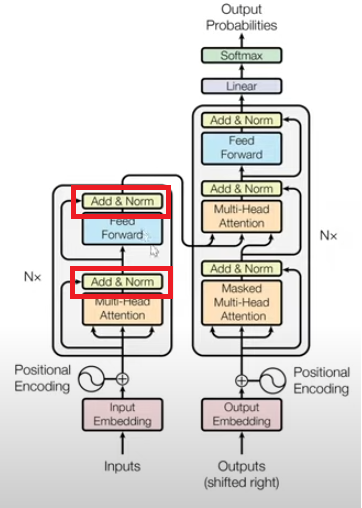

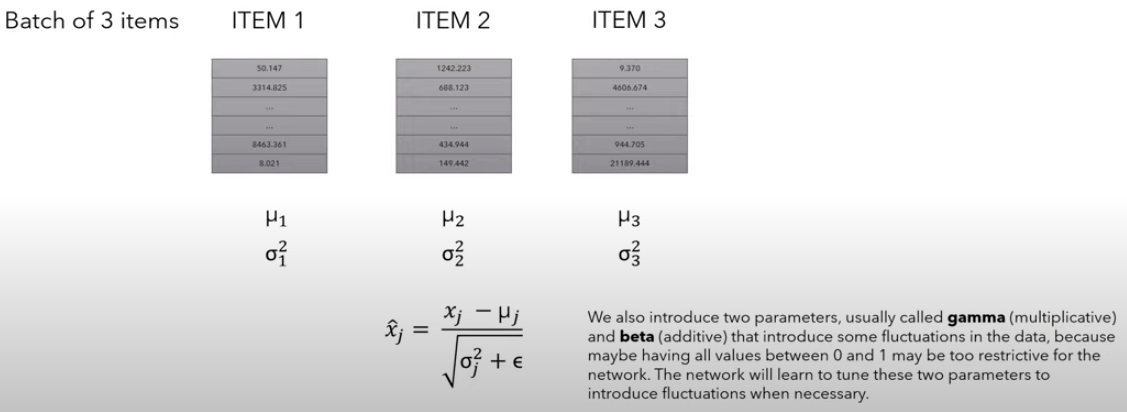

### TASK 2:

The layer normalization is done across the feature dimension unlike batch normalization with is done across the batch dimensions. If we given an input of shape `(batch, seq_len, model_dim)` to the `LayerNormalization`, it will normalize the input across the `model_dim` (`dim=2` or `dim=-1`). To do this we first calculate the mean across the feature dimension `x.mean(dim = -1, keepdim = True)` and then get the standard deviation `x.std(dim = -1, keepdim = True)` and finally normalize the input x with the calculated mean and standard deviation.

Keep in mind that we do not only normalize the input in the layer normalization, but we also scale with a learnable parameter vector `alpha` with the same size as `model_dim` and initialized to 1, and add a learnable bias vector `bias` to the normalized values so that the model can scale the output of the layer normalizatin as needed.

Your task is to complete the two lines in the cell below, first you need to normalize the input x with the calculated `mean` and `std` and then you will multiple the output matrix with `alpha` and add the `bias` to it.

In [6]:
class LayerNormalization(nn.Module):

    def __init__(self, features: int, eps:float=10**-6) -> None:
        super().__init__()
        self.eps = eps
        self.alpha = nn.Parameter(torch.ones(features)) # alpha is a learnable parameter
        self.bias = nn.Parameter(torch.zeros(features)) # bias is a learnable parameter

    def forward(self, x):
        # x: (batch, seq_len, hidden_size)
         # Keep the dimension for broadcasting
        mean = x.mean(dim = -1, keepdim = True) # (batch, seq_len, 1)
        # Keep the dimension for broadcasting
        std = x.std(dim = -1, keepdim = True) # (batch, seq_len, 1)

        ### START CODE HERE ###
        x =  (x - mean)/(std + self.eps) # Normalize the x by subtracting mean from it and dividing by (std+self.eps)
                                          # eps is to prevent dividing by zero or when std is very small

        x = (x * self.alpha) + self.bias           # Multiply the normalized x with alpha and add the bias
        ### END CODE HERE ###

        return x

#### Code Breakdown

1. **Initialization (`__init__` method)**:
   - **Parameters**:
     - `features`: The number of features in the input (typically the hidden size of the model).
     - `eps`: A small constant added to the denominator for numerical stability (default is \(10^{-6}\)).
   - **Learnable Parameters**:
     - `self.alpha = nn.Parameter(torch.ones(features))`: This parameter scales the normalized output. It is initialized to ones, allowing the model to learn the appropriate scaling during training.
     - `self.bias = nn.Parameter(torch.zeros(features))`: This parameter shifts the normalized output. It is initialized to zeros.

2. **Forward Method**:
   - The `forward` method takes an input tensor `x`, which has the shape `(batch, seq_len, hidden_size)`.
   - **Mean and Standard Deviation Calculation**:
     - `mean = x.mean(dim=-1, keepdim=True)`: Computes the mean of the features across the last dimension (hidden size) while keeping the dimension for broadcasting.
     - `std = x.std(dim=-1, keepdim=True)`: Computes the standard deviation in a similar manner.
   - **Normalization**:
     - The input `x` is normalized by subtracting the mean and dividing by the standard deviation, with `eps` added to prevent division by zero.
   - **Final Output**:
     - The normalized output is scaled by `self.alpha` and shifted by `self.bias`, resulting in the final output.

#### Key Points
- Layer normalization is applied across the features of each individual example, making it particularly useful in sequence models like Transformers.
- By normalizing the input at each layer, it helps the model train faster and achieve better performance.
- The learnable parameters (`alpha` and `bias`) allow the model to adaptively adjust the normalized output, providing more flexibility.


### Residual Connection

The `ResidualConnection` class implements a residual connection, which is a key component of the Transformer architecture. Residual connections help with gradient flow during training and facilitate the learning of deeper networks by allowing the model to learn adjustments rather than full transformations.

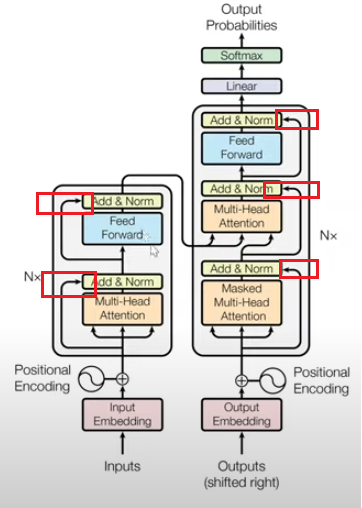

### TASK 3

The `ResidualConnection` class below as the name suggests implements the addition of the input to the output of a `sublayer` provided as the argument of the forward function and it is generally the multi-head attention layer.

Your task is to first apply the normalization layer on the input, apply the sublayer, apply dropout and then add the input back to the resulting vector and return the final output.

Note: In the diagram the normalization is done after application of sublayer, however, in most implementations online, the layer normalization is done before applying the sublayer.

In [7]:
class ResidualConnection(nn.Module):

        def __init__(self, features: int, dropout: float) -> None:
            super().__init__()
            self.dropout = nn.Dropout(dropout)
            self.norm = LayerNormalization(features)

        def forward(self, x, sublayer):
            ### START CODE HERE ###
            out = self.norm(x)            # Apply the normalization layer on x
            out = sublayer(out)            # Apply the sublayer passed in the arguments on out
            out = self.dropout(out)            # Apply the dropout on the output of the sublayer
            out = out + x          # Add the input x to the output of the dropout layer
            ### END CODE HERE ###
            return out

======================================================================================================================================================================================================================================

### Feed Forward Block

The `FeedForwardBlock` class implements a feed-forward neural network block, which is a crucial component of the Transformer architecture highlighted with a red box in the image below. Each Transformer layer contains a feed-forward network that processes the outputs of the attention mechanism, allowing the model to learn complex transformations.

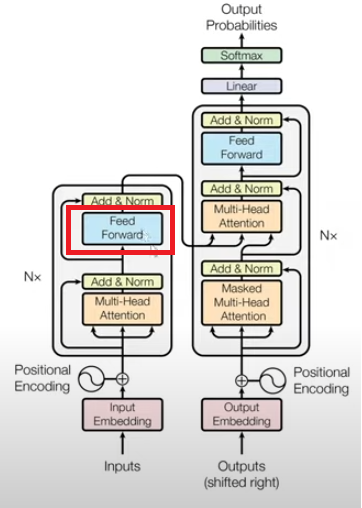


### Task 4

The feed-forward layer in the transformer has two linear layers with ReLU and Dropout layers between them. Please complete the code in the cell below and apply the feed-forward layer on the input.

In [8]:
class FeedForwardBlock(nn.Module):

    def __init__(self, d_model: int, d_ff: int, dropout: float) -> None:
        super().__init__()
        self.linear_1 = nn.Linear(d_model, d_ff) # w1 and b1
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(d_ff, d_model) # w2 and b2

    def forward(self, x):
        # (batch, seq_len, d_model) --> (batch, seq_len, d_ff) --> (batch, seq_len, d_model)

        ### START CODE HERE ###
        x = self.linear_1(x)                 # Apply linear1 layer
        x = nn.Relu()(x)                 # Apply relu activation
        x = self.droput(x)                 # Apply dropout
        x = self.linear_2(x)                 # Apply linear2 layer
        ### END CODE HERE ###

        return x


#### Code Breakdown

1. **Initialization (`__init__` method)**:
   - **Parameters**:
     - `d_model`: The dimensionality of the input and output embeddings (typically the hidden size).
     - `d_ff`: The dimensionality of the hidden layer in the feed-forward network. This is usually larger than `d_model`.
     - `dropout`: The dropout rate used for regularization.
   - **Layers**:
     - `self.linear_1 = nn.Linear(d_model, d_ff)`: This layer transforms the input from `d_model` dimensions to `d_ff` dimensions.
     - `self.dropout = nn.Dropout(dropout)`: This dropout layer randomly sets some of the activations to zero during training, helping to prevent overfitting.
     - `self.linear_2 = nn.Linear(d_ff, d_model)`: This layer transforms the output back from `d_ff` dimensions to `d_model` dimensions.

2. **Forward Method**:
   - The `forward` method takes an input tensor `x` with shape `(batch, seq_len, d_model)`.
   - The sequence of operations is as follows:
     - The input is passed through the first linear layer (`self.linear_1`), which outputs a tensor of shape `(batch, seq_len, d_ff)`.
     - A ReLU activation function is applied, introducing non-linearity.
     - Dropout is applied to the activations to help regularize the model.
     - Finally, the output is passed through the second linear layer (`self.linear_2`), resulting in a tensor of shape `(batch, seq_len, d_model)`.

#### Key Points
- The feed-forward network consists of two linear transformations with a ReLU activation in between, enabling the model to learn complex representations.
- The inclusion of dropout helps prevent overfitting, particularly important in large models like Transformers.
- This block is applied independently to each position in the sequence, ensuring that the feed-forward network operates in a position-wise manner.



======================================================================

### Multi-Head Attention Block

Now we introduce the most important part of the transformer model, which is the multihead attention block highlighted in the image below.


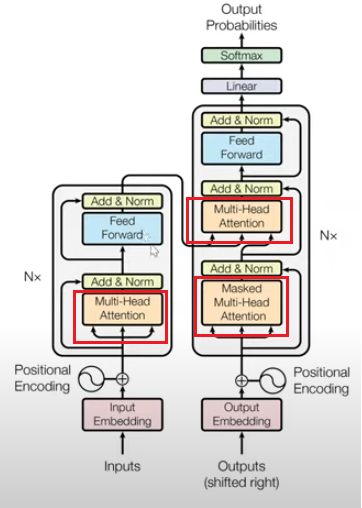

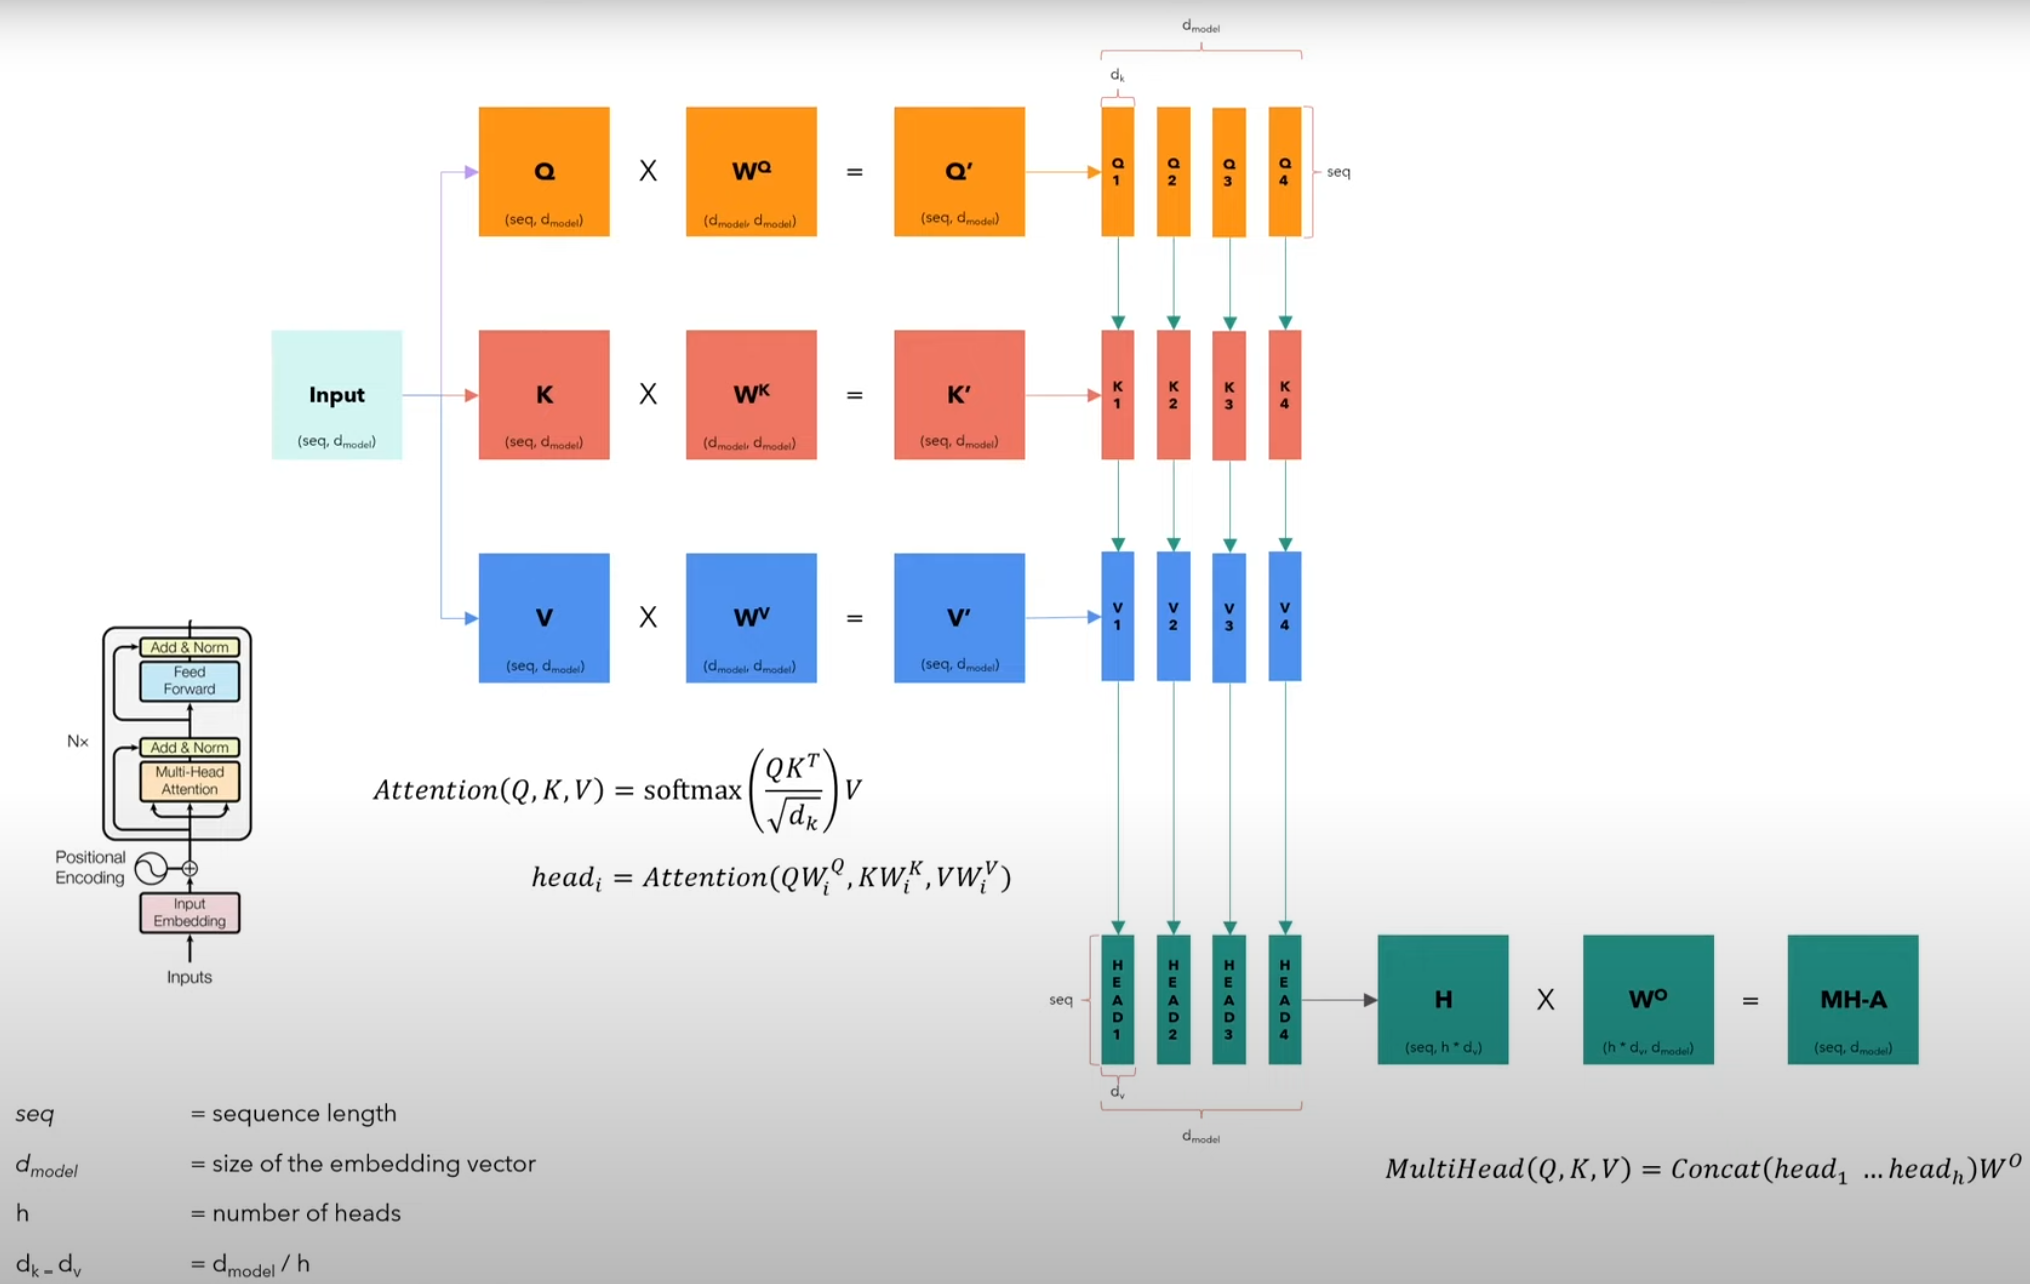

### Multi-Head Attention Block (Detailed Explanation)

The `MultiHeadAttentionBlock` is a fundamental component of the Transformer architecture, designed to enable the model to focus on different parts of the input sequence simultaneously. This mechanism enhances the model's capacity to understand complex dependencies and relationships within the data, which is crucial for tasks such as translation, summarization, and more.

#### Key Concepts

1. **Attention Mechanism**:
   - The core idea of attention is to compute a weighted sum of values based on how relevant they are to a given query. In the context of language, a query might represent a word in a sentence that is trying to gather context from other words.
   - The attention scores are computed using the dot product of the query and key vectors, which indicates how much focus should be placed on each token in relation to the query.

2. **Multi-Head Attention**:
   - Instead of using a single attention mechanism, multi-head attention splits the input embeddings into multiple heads. Each head learns to focus on different aspects of the input.
   - By allowing multiple attention mechanisms to operate in parallel, the model can capture a broader range of information and complex relationships in the data.
   - After computing the attention scores for each head, the outputs are concatenated and passed through a final linear transformation to combine the information learned by each head.

#### Detailed Breakdown of the Operations

1. **Input Transformation**:
   - The input embeddings (query, key, and value) are projected into separate spaces using learned linear transformations:
     - **Query Projection**: The input query is transformed into a query representation for attention.
     - **Key Projection**: The same input (or a different one) is transformed into a key representation.
     - **Value Projection**: The input is also transformed into a value representation.

2. **Reshaping for Parallel Processing**:
   - After linear transformation, the tensors are reshaped to facilitate multi-head processing:
     - Each input tensor of shape `(batch, seq_len, d_model)` is reshaped to `(batch, seq_len, h, d_k)`, where `h` is the number of heads and `d_k` is the dimensionality for each head.
     - This allows each head to operate independently on its own subset of the input features.

3. **Attention Score Calculation**:
   - For each head, the attention scores are computed using the formula:
   
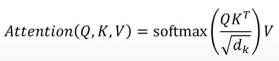



4. **Masking**:
   - An optional mask can be applied to prevent attending to certain positions (e.g., padding or future tokens in autoregressive tasks). This is done by setting attention scores of masked positions to a very low value (effectively negative infinity), ensuring that they contribute zero to the output.

5. **Combining Outputs**:
   - The output from each head is concatenated back together to form a single representation, and then a linear transformation is applied to bring it back to the original dimensionality \(d_model\).
   - This final linear layer combines the information from all heads into a unified representation that retains the complexity of the multi-head attention mechanism.

#### Advantages of Multi-Head Attention
- **Diversity of Attention**: Each head can learn to attend to different aspects of the sequence, allowing the model to capture varied relationships.
- **Rich Representations**: By combining the outputs of multiple heads, the model generates richer and more informative representations of the input.
- **Parallel Computation**: The parallel nature of multi-head attention allows for more efficient processing, taking advantage of modern computational resources.

Overall, the Multi-Head Attention Block enhances the Transformer's ability to process and understand complex sequences, making it a powerful tool for a wide range of natural language processing tasks.


### Task 5

Implement the MultiHeadAttentionBlock class in the cell below by completing the code where required. Understand the code and follow the instructions in the comments to complete the code.

In [9]:
class MultiHeadAttentionBlock(nn.Module):

    def __init__(self, d_model: int, h: int, dropout: float) -> None:
        super().__init__()

        self.d_model = d_model # Embedding vector size
        self.h = h # Number of heads that we are going to use for multihead attention

        # We should make sure d_model is divisible by h
        assert d_model % h == 0, "d_model is not divisible by h"

        self.d_k = d_model // h # Dimension of vector seen by each head
        # Since we are using h number of heads, we divide the embedding dimension
        # d_model into d_model/h= d_k

        # We create linear layers to form query, key and value vectors
        # The layer for the query has been initialized below.
        self.w_q = nn.Linear(d_model, d_model, bias=False) # Wq

        # Please use the same method of initialization for the key and vector layers below.
        # Input features of the layer would be d_model and output would also be the d_model
        # Set the bias to False

        ### START CODE HERE ###
        self.w_k = nn.Linear(d_model, d_model, bias=False)        # Wk
        self.w_v = nn.Linear(d_model, d_model, bias=False)          # Wv
        ### END CODE HERE ###

        self.w_o = nn.Linear(d_model, d_model, bias=False) # Wo
        # The w_o is a linear layer that fuses the results from different heads of the multihead attention
        # The outputs from the multi-head attention are concatenated to form a vector of size d_model
        # because d_k * h = d_model

        self.dropout = nn.Dropout(dropout)

    @staticmethod
    def attention(query, key, value, mask, dropout: nn.Dropout):
        d_k = query.shape[-1]

        # Apply the formula for attention between query and key from the paper
        # The @ operator does the dot product between the two matrices of query and key.
        # We switch the last two dimensions of the key matrix so that it can be dot
        # multiplied with the query: (batch, h, seq_len, dk) x (batch, h, dk , seq_len) -->(batch, h, seq_len, seq_len)
        # You can do this with the key.transpose() method, you will have to provide the last two dimensions to the
        # transpose method so that they can be switched

        #Calculate the attention scores below using the instructions above:
        #(batch, h, seq_len, dk) x (batch, h, dk , seq_len) -->(batch, h, seq_len, seq_len)

        ### START CODE HERE ###

        attention_scores =  query @ key.transpose(-2,-1)  # Use the @ and transpose function to perform dot product between query and key.
        attention_scores =  attention_scores / (math.sqrt(d_k))  # divide the resulting attention scores by the square root of d_k (math.sqrt())

        ### END CODE HERE ###

        # Use mask if required and mask is not None on the attention scores to mask out the padded tokens in the sequence
        # Or to mask the future tokens when providing input to the decoder.
        if mask is not None:
            # Write a very low value (indicating -inf) to the positions where mask == 0
            attention_scores.masked_fill_(mask == 0, -1e9)

        # After calculating attention scores and applying the mask on the on the attention matrix
        # we Need to apply the softmax operation along the last dimension (-1) of the attention scores matrix

        ### START CODE HERE ###
        attention_scores = attention_scores.softmax(attention_scores, dim = -1)                       # (batch, h, seq_len, seq_len) # Apply softmax
        ### END CODE HERE ###


        if dropout is not None:
            attention_scores = dropout(attention_scores)
        # (batch, h, seq_len, seq_len) --> (batch, h, seq_len, d_k)

        # After applying softmax on the attention scores we need to multiply the
        # attention scores with the value matrix. Use the same @ operation as before
        # but this time without using the transpose operation because it is not
        # needed here.

        # (batch, h, seq_len, seq_len) x (batch, h, seq_len, d_k) --> (batch, h, seq_len, d_k)

        ### START CODE HERE ###
        out = attention_scores @ value                     # dot product between attention_scores and value matrices
        ### END CODE HERE ###

        # return attention scores which can be used for visualization
        return out, attention_scores

    def forward(self, q, k, v, mask):

        # The query q, key k, and value v matrices here are actually the inputs
        # to the multi-head attention block so we have to apply the linear layers
        # that we initialized in the constructor w_q, w_k and w_v on the respective inputs.

        ### START CODE HERE ###
        query = self.w_q(q)          #  Apply the w_q layer on q (batch, seq_len, d_model) --> (batch, seq_len, d_model)
        key = self.w_k(k)             # (batch, seq_len, d_model) --> (batch, seq_len, d_model)
        value = self.w_v(v)           # (batch, seq_len, d_model) --> (batch, seq_len, d_model)
        ### END CODE HERE ###

        # Once we get the query, key and value matrices each of shape (batch, seq_len, d_model)
        # we have to divide the d_model dimensions into h parts, 1 for each head.
        # So we are going to have d_model/h = d_k, hence we reshape the matrices
        # as follows:

        # (batch, seq_len, d_model) --> (batch, seq_len, h, d_k) --> (batch, h, seq_len, d_k)
        # We also have to switch the dimensions of seq_len with h so that we can apply
        # attention operations with respect to the seq_len and d_k dimensions, it would look
        # something like this: (batch, seq_len, h, d_k) --> (batch, h, seq_len, d_k)
        query = query.view(query.shape[0], query.shape[1], self.h, self.d_k).transpose(1, 2)

        # Do the same thing for key and value matrices as done for the query above.
        ### START CODE HERE ###
        key = key.view(key.shape[0], key.shape[1], self.h, self.d_k).transpose(1, 2)
        value = value.view(value.shape[0], value.shape[1], self.h, self.d_k).transpose(1, 2)
        ### END CODE HERE ###

        # Here we apply the attention mechanism using the static function "attention" from this class
        # We pass the query, key, value and mask matrices to this function.
        x, self.attention_scores = MultiHeadAttentionBlock.attention(query, key, value, mask, self.dropout)

        # Here we combine all the heads together. We had different head results in the x tensor
        # that came from the application of the attention function above.

        # (batch, h, seq_len, d_k) --> (batch, seq_len, h, d_k) --> (batch, seq_len, d_model)
        x = x.transpose(1, 2).contiguous().view(x.shape[0], -1, self.h * self.d_k)

        # Finally we pass the concatenated attention heads through the final linear layer
        # so that it can fuse the information of the different heads together
        # (batch, seq_len, d_model) --> (batch, seq_len, d_model)
        # Apply the w_o layer on x below

        ### START CODE HERE ###
        x = self.w_o(x)
        ### END CODE HERE ###

        return x


### TASK 6

Please explain what is happening in the line of code in the cell above rewritten below:

`x = x.transpose(1, 2).contiguous().view(x.shape[0], -1, self.h * self.d_k)`

Why are we using the transpose, contiguous and view functions?

transpose(1, 2) switches the sequence and head dimensions, changing the shape from (batch, heads, seq_len, d_k) to (batch, seq_len, heads, d_k) so the heads align with each token.

contiguous() ensures the tensor is stored correctly in memory after transpose, since view() requires a continuous memory layout.

view(...) flattens the last two dimensions (heads × d_k) back into the original d_model, restoring the final shape to (batch, seq_len, d_model).

#### Code Breakdown

1. **Initialization (`__init__` method)**:
   - **Parameters**:
     - `d_model`: The dimensionality of the input and output embeddings (typically the hidden size).
     - `h`: The number of attention heads. This allows the model to attend to information from different representation subspaces.
   - **Assertions**:
     - `assert d_model % h == 0`: Ensures that `d_model` is divisible by `h` so that each head has an equal representation size.
   - **Dimensions**:
     - `self.d_k = d_model // h`: The dimension of the key (and query) vectors for each head.
   - **Linear Layers**:
     - `self.w_q`, `self.w_k`, `self.w_v`: Linear transformations for queries, keys, and values, respectively. They map the input to the corresponding representation for attention.
     - `self.w_o`: A linear transformation that combines the outputs of all attention heads.
   - **Dropout**: A dropout layer to prevent overfitting.

2. **Attention Static Method**:
   - The `attention` method computes the attention scores and output based on the provided queries, keys, and values.
   - **Score Calculation**:
     - `attention_scores` : Computes the scaled dot-product attention scores.
   - **Masking**:
     - If a mask is provided, it sets masked positions to a very low value to prevent attending to those tokens.
   - **Softmax**:
     - Applies softmax to the attention scores to obtain attention weights.
   - **Output Calculation**:
     - The attention scores are multiplied by the values to obtain the final output of the attention mechanism.

3. **Forward Method**:
   - The `forward` method takes queries `q`, keys `k`, values `v`, and an optional mask.
   - **Linear Transformations**:
     - Each input is transformed into query, key, and value representations using their respective linear layers.
   - **Reshaping for Multi-Head Attention**:
     - The query, key, and value tensors are reshaped to facilitate multi-head attention processing. They are rearranged into the shape `(batch, seq_len, h, d_k)`.
   - **Attention Calculation**:
     - The `attention` method is called to compute the output and attention scores.
   - **Combining Heads**:
     - The outputs from all heads are concatenated and reshaped back to `(batch, seq_len, d_model)` before being transformed by the output linear layer `self.w_o`.

======================================================================

### Encoder Block

The `EncoderBlock` class is a fundamental building block of the Transformer’s encoder. It combines self-attention and feed-forward neural network components, along with residual connections and normalization, to process input sequences effectively.

#### Overview

Each `EncoderBlock` consists of two main subcomponents: a multi-head self-attention mechanism and a feed-forward network. The self-attention block allows the model to focus on different parts of the input sequence, while the feed-forward network applies a series of transformations to enhance the representation.

#### Structure

1. **Self-Attention**: The self-attention block computes attention scores for the input sequence, allowing the model to weigh the significance of different tokens based on their relationships. This helps in capturing context and dependencies effectively.

2. **Feed-Forward Network**: After the self-attention computation, the output is passed through a feed-forward network, which consists of linear transformations and activation functions. This network processes the attention-enhanced representations, allowing the model to learn more complex patterns.

3. **Residual Connections**: Each subcomponent (self-attention and feed-forward) is wrapped with a residual connection. This means that the original input is added back to the output of each subcomponent, helping to preserve information and improve gradient flow during training.

4. **Layer Normalization**: After each residual connection, layer normalization is applied. This helps stabilize the learning process and ensures that the outputs of each layer maintain consistent scales.

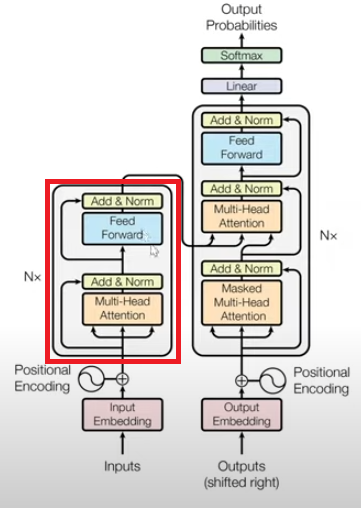

In [10]:
class EncoderBlock(nn.Module):

    def __init__(self, features: int, self_attention_block: MultiHeadAttentionBlock, feed_forward_block: FeedForwardBlock, dropout: float) -> None:
        super().__init__()
        # We have three parts in a single encoder block

        # 1) the self attention block
        self.self_attention_block = self_attention_block

        # 2) The feed forward block
        self.feed_forward_block = feed_forward_block

        # 3) Two residual connections: 1 for the output of the self_attention_block
        #                              2 for the output of the feed_forward_block
        self.residual_connections = nn.ModuleList([ResidualConnection(features, dropout) for _ in range(2)])

    def forward(self, x, src_mask):
        x = self.residual_connections[0](x, lambda x: self.self_attention_block(x, x, x, src_mask))
        x = self.residual_connections[1](x, self.feed_forward_block)
        return x

### Task 7

Please explain the following lines of code in the forward function in the above cell:

`x = self.residual_connections[0](x, lambda x: self.self_attention_block(x, x, x, src_mask))`

`x = self.residual_connections[1](x, self.feed_forward_block)`

These two lines apply residual connections around the self-attention block and feed-forward block. The first line adds the original input to the output of self-attention, and the second line adds the updated input to the feed-forward output. This helps preserve important information, stabilizes training, and prevents degradation of the representations.

======================================================================

### The Encoder: Stacking Multiple Encoder Blocks

The `Encoder` class consists of a stack of `EncoderBlock` instances. It processes the input sequence through multiple layers, each refining the representation of the input.

#### Overview

The `Encoder` takes the input sequence and a corresponding mask, passing the input through each `EncoderBlock` in sequence. After processing through all the layers, layer normalization is applied to the final output.

#### Benefits

- **Hierarchical Representation**: By stacking multiple `EncoderBlock` layers, the model can learn increasingly abstract representations of the input sequence.
- **Efficiency**: The self-attention mechanism allows for parallel processing of input sequences, improving computational efficiency.
- **Scalability**: The architecture can be scaled up by increasing the number of layers or the dimensionality of the model, making it versatile for a range of tasks.


In [11]:
class Encoder(nn.Module):

    def __init__(self, features: int, layers: nn.ModuleList) -> None:
        super().__init__()
        self.layers = layers
        self.norm = LayerNormalization(features)

    def forward(self, x, mask):
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)


======================================================================

### Decoder Block

The `DecoderBlock` class is a critical component of the Transformer’s decoder architecture. It integrates self-attention, cross-attention, and feed-forward layers, along with residual connections and normalization, to generate output sequences based on encoded input data.

#### Overview

Each `DecoderBlock` is designed to process the target sequence while considering both previous target information (self-attention) and the encoded input from the encoder (cross-attention). This dual attention mechanism enables the decoder to generate contextually relevant outputs.

#### Structure

1. **Self-Attention**: The first component is a multi-head self-attention mechanism, which allows the decoder to focus on different parts of the target sequence itself. This helps the model understand the dependencies within the target sequence as it generates each token.

2. **Cross-Attention**: The second component is a cross-attention mechanism that takes the encoder's output as input. This allows the decoder to incorporate information from the encoder, which represents the source sequence. By attending to the encoder's output, the decoder can effectively align the generated sequence with the input.

3. **Feed-Forward Network**: After both attention computations, the output is processed through a feed-forward network, which applies additional transformations to enhance the representation.

4. **Residual Connections**: Each of the three components (self-attention, cross-attention, and feed-forward) is wrapped in a residual connection. This means the input to each layer is added back to its output, facilitating better gradient flow and preserving important information.

5. **Layer Normalization**: Although not explicitly shown in the `forward` method, layer normalization is typically applied after each residual connection to stabilize the output.

### Benefits

- **Contextual Generation**: By using both self-attention and cross-attention, the `DecoderBlock` can generate outputs that are not only aware of the target context but also informed by the source input.
- **Rich Representations**: The combination of multiple attention mechanisms and feed-forward networks enables the model to learn complex patterns and relationships, making it suitable for tasks such as machine translation and text generation.
- **Flexibility**: The architecture can be easily adapted to various tasks by modifying the number of layers or the dimensionality, allowing for a wide range of applications in natural language processing.



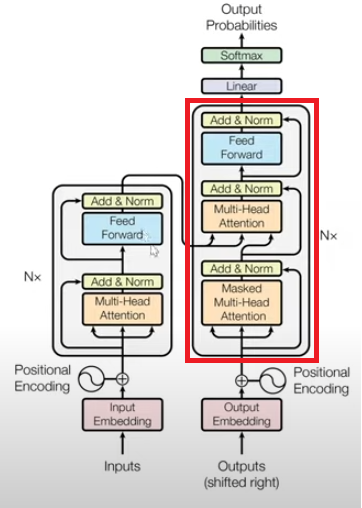

In [12]:
class DecoderBlock(nn.Module):

    def __init__(self, features: int, self_attention_block: MultiHeadAttentionBlock, cross_attention_block: MultiHeadAttentionBlock, feed_forward_block: FeedForwardBlock, dropout: float) -> None:
        super().__init__()
        self.self_attention_block = self_attention_block
        self.cross_attention_block = cross_attention_block
        self.feed_forward_block = feed_forward_block
        self.residual_connections = nn.ModuleList([ResidualConnection(features, dropout) for _ in range(3)])

    def forward(self, x, encoder_output, src_mask, tgt_mask):
        x = self.residual_connections[0](x, lambda x: self.self_attention_block(x, x, x, tgt_mask))
        x = self.residual_connections[1](x, lambda x: self.cross_attention_block(x, encoder_output, encoder_output, src_mask))
        x = self.residual_connections[2](x, self.feed_forward_block)
        return x

### Task 8:

You have seen the code and implementation for the encoder block, the decoder block is implemented in the above cell.

**Question1:** What is the main difference between the encoder block and the decoder block?

**Question2:** In the above code cell, why does the self_attention_block has input `x` 3 times like `self.self_attention_block(x, x, x, tgt_mask)` whereas the cross_ attention block has `x` as the first input and `encoder_output` as the other two inputs like `self.cross_attention_block(x, encoder_output, encoder_output, src_mask)`. Whats the difference between the two?

Q1: The decoder does not start with the full translated sentence. Instead, it generates the translation one token at a time. After each token is produced, the decoder uses two attention mechanisms to determine the next one:

Masked self-attention allows the decoder to look only at the tokens it has generated so far, ensuring it cannot “peek ahead” at future words.

Cross-attention allows the decoder to compare its partial output with the encoded representation of the original sentence. This helps the decoder decide which token best matches the meaning of the source input.

This process repeats until the decoder predicts an end token, gradually building the full translated sentence step by step.

Q2: Self-attention in the decoder only looks at the tokens the decoder has already generated to maintain grammar and sequence consistency, while cross-attention uses the encoder output to decide what the next translated word should be based on the original input sentence.

======================================================================

### The Decoder: Stacking Multiple Decoder Blocks

The `Decoder` class is responsible for managing the stack of `DecoderBlock` layers, enabling the sequential processing of the target sequence while attending to both the target and source sequences. It is a key component of the Transformer’s decoder, used for tasks such as language generation and sequence-to-sequence translation.

#### Overview

The `Decoder` processes the input through multiple layers of `DecoderBlock` to transform the target sequence into meaningful outputs, taking into account the encoder’s output (which represents the source sequence). After passing through the layers, it normalizes the final output to ensure consistent scaling of the representations.

#### Structure

1. **Layers**: The `Decoder` is composed of a stack of `DecoderBlock` layers, each responsible for applying self-attention, cross-attention, and feed-forward transformations. The depth (number of layers) determines the complexity and capacity of the decoder to handle more intricate patterns.

2. **Forward Process**:
   - The input (`x`) is passed through each `DecoderBlock` sequentially.
   - In each `DecoderBlock`, the model first applies self-attention on the target sequence, followed by cross-attention on the encoder's output, and finally a feed-forward network.
   - The `src_mask` and `tgt_mask` help the model focus on the relevant parts of the source and target sequences, respectively.

3. **Layer Normalization**: Once all `DecoderBlock` layers have processed the input, a final layer normalization is applied. This helps maintain numerical stability and ensures that the output is well-scaled and suitable for subsequent tasks, such as softmax classification.



In [13]:
class Decoder(nn.Module):

    def __init__(self, features: int, layers: nn.ModuleList) -> None:
        super().__init__()
        self.layers = layers
        self.norm = LayerNormalization(features)

    def forward(self, x, encoder_output, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, encoder_output, src_mask, tgt_mask)
        return self.norm(x)


======================================================================

### Projection Layer

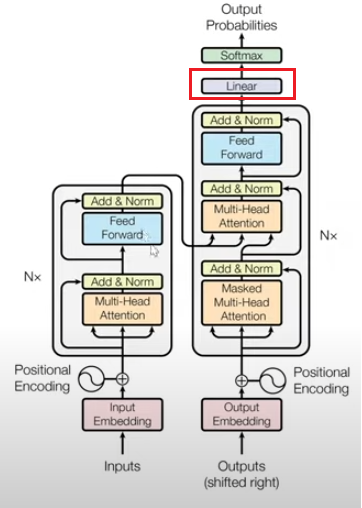



The `ProjectionLayer` class is a simple yet crucial component of the Transformer model, responsible for converting the final hidden representations of the decoder into logits for each token in the vocabulary. This is the final step before applying a softmax function during tasks such as language modeling or machine translation, where the model generates a probability distribution over the vocabulary for each token.

#### Overview

After the decoder processes the input sequence and produces a hidden representation of size `d_model`, the `ProjectionLayer` takes these embeddings and maps them to a space where each dimension corresponds to a token in the vocabulary. This is achieved using a linear transformation.

#### Structure

- **Linear Projection**: The core of the projection layer is a single linear layer (`nn.Linear`) that transforms the decoder output of shape `(batch, seq_len, d_model)` into logits of shape `(batch, seq_len, vocab_size)`. This means that for each token in the sequence, the model predicts a score for every possible token in the vocabulary.

#### Forward Process

The input to the `ProjectionLayer` is the output from the decoder, which has a shape corresponding to the batch size, sequence length, and the model’s hidden dimension (`d_model`). The linear layer transforms this into logits, which have a shape corresponding to the batch size, sequence length, and the vocabulary size. These logits are then typically passed through a softmax function to generate probabilities.

#### Benefits

- **Vocabulary Mapping**: This layer provides the essential mapping from the model's internal representations to a format that corresponds to the target vocabulary, enabling the generation of output tokens.
- **Scalability**: The `ProjectionLayer` can handle large vocabularies efficiently, making it suitable for tasks with extensive token sets, such as machine translation or text generation.
- **Final Step in Prediction**: As the final layer before producing output, it plays a critical role in determining the model's prediction by converting complex embeddings into actionable token probabilities.



### Task 9

Complete the code below by applying the projection layer on the input below:

In [14]:
class ProjectionLayer(nn.Module):

    def __init__(self, d_model, vocab_size) -> None:
        super().__init__()
        self.proj = nn.Linear(d_model, vocab_size)

    def forward(self, x) -> None:
        # (batch, seq_len, d_model) --> (batch, seq_len, vocab_size)

        ### START CODE HERE ###
        x = self.proj(x)            # Apply the linear layer for projection here (proj)
        ### END CODE HERE ###

        return x

======================================================================

### The Transformer Class: Bringing everything together

The `Transformer` class is the central model that integrates both the encoder and decoder architectures for tasks like machine translation, text generation, and sequence-to-sequence modeling. This model leverages the attention mechanism and fully connected layers to process and generate sequences.

#### Overview

The Transformer model is designed to map input sequences (e.g., sentences in one language) to output sequences (e.g., translations in another language) without relying on recurrent or convolutional layers. Instead, it uses multi-head self-attention and feed-forward networks to learn complex relationships and dependencies between tokens.

#### Structure

1. **Encoder**:
   - The encoder is composed of multiple `EncoderBlock` layers, each using self-attention to process the input sequence.
   - The input is first passed through an `InputEmbeddings` layer to convert tokens into dense vector representations, followed by a `PositionalEncoding` layer to add information about the sequence order.
   - The encoder produces a context-aware representation of the source sequence.

2. **Decoder**:
   - The decoder mirrors the structure of the encoder but also includes cross-attention to attend to the encoder's output.
   - The decoder processes the target sequence while using information from the encoder's representation to generate predictions.
   - Similar to the encoder, the input is first embedded and passed through a positional encoding layer before going through multiple `DecoderBlock` layers.

3. **Embedding and Positional Encoding**:
   - Both the source and target sequences are embedded into dense vectors of size `d_model` using the `InputEmbeddings` class.
   - The `PositionalEncoding` layers add positional information to these embeddings to help the model understand the order of tokens in the sequence.

4. **Projection Layer**:
   - The `ProjectionLayer` maps the decoder's output to the vocabulary space, generating logits for each token in the sequence. This is followed by a softmax to produce a probability distribution over the vocabulary for each position in the output sequence.

#### Forward Process

1. **Encoding**:
   - The source sequence is passed through the source embedding layer and the positional encoding layer. This embedded sequence is then processed by the encoder, generating a context-rich representation of the source sequence.

2. **Decoding**:
   - The target sequence is passed through the target embedding and positional encoding layers. The decoder then processes this sequence in conjunction with the encoder's output, attending to both the target and source sequences.
   
3. **Projection**:
   - The decoder’s output is passed through the `ProjectionLayer`, which converts the decoder’s hidden state into a vector of logits corresponding to the vocabulary size.


###Task 10:

In the Transformer class below, we pass all the components of the transformer when initiating an instance of this class. You can see the various components as the arguments in the __init__() function like the encoder, decoder, src_embed, tgt_embedding, etc.

This class has three other functions the `encode()`, the `decode()` and `project`. You will need to perform the appropriate operations in each function below

Please complete the code below by following the instructions in the comments and perform the necessary operations required in the encoder, decoder and project functions.  

In [15]:
class Transformer(nn.Module):

    def __init__(self, encoder: Encoder, decoder: Decoder, src_embed: InputEmbeddings, tgt_embed: InputEmbeddings, src_pos: PositionalEncoding, tgt_pos: PositionalEncoding, projection_layer: ProjectionLayer) -> None:
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder

        self.src_embed = src_embed
        self.tgt_embed = tgt_embed

        self.src_pos = src_pos
        self.tgt_pos = tgt_pos

        self.projection_layer = projection_layer

    def encode(self, src, src_mask):

        ### START CODE HERE ###
        # (batch, seq_len, d_model)
        src =                     # Apply the source embedding layer on the encoder input
        src =                     # Apply the positional encoding on the output
        src =                     # Apply the encoder on the output of the positional encoding layer along with the src_mask (src, src_mask)
        ### END CODE HERE ###

        return src

    def decode(self, encoder_output: torch.Tensor, src_mask: torch.Tensor, tgt: torch.Tensor, tgt_mask: torch.Tensor):

        ### START CODE HERE ###
        # (batch, seq_len, d_model)
        tgt =                     # Apply the target embedding layer on the decoder input
        tgt =                     # Apply the positional encoding on the output of the target embedding layer

        tgt =                     # Apply the decoder on the output of the positional encoding layer
                                  # In addition to that you will also have to provide the encoder output, source mask and target mask (tgt, encoder_output, src_mask, tgt_mask)
                                  # The encoder output is required for computing cross-attention between encoder and decoder
        ### END CODE HERE ###

        return tgt

    def project(self, x):
        # (batch, seq_len, vocab_size)
        ### START CODE HERE ###
        x =                       # Apply the projection layer on the input x
        ### END CODE HERE ###

        return x

SyntaxError: invalid syntax (ipython-input-496952783.py, line 21)

### Building the Transformer

The `build_transformer` function is responsible for constructing an instance of the Transformer model with specified hyperparameters such as the embedding size (`d_model`), the number of encoder and decoder layers (`N`), the number of attention heads (`h`), and other settings.

It uses all the classes that we created until now to initialize various parts of the transformer and then combine all those parts into a transformer using the `Transformer` class that we created in the previous code cell.


### Task 11

We are going to implement the `build_transformer` function now where you are going to first initialize the different parts of your transformer model using the classes and functions that we created before and then combine them into a transformer using the `Transformer` class.

Please follow the instructions in the code cell below to implement the `build_transformer` function.

In [ ]:
def build_transformer(src_vocab_size: int, tgt_vocab_size: int, src_seq_len: int, tgt_seq_len: int, d_model: int=512, N: int=6, h: int=8, dropout: float=0.1, d_ff: int=2048) -> Transformer:

    ### START CODE HERE ###
    # Create the embedding layers
    src_embed =                           # Create an embedding layer for the source language.You will have to provide the embedding size and source language vocabulary size. (d_model, src_vocab_size)
    tgt_embed =                           # Do the same for target language with the same embedding size but target vocabulary size (d_model, tgt_vocab_size)
    ### END CODE HERE ###

    # Create the positional encoding layers
    ### START CODE HERE ###
    src_pos =                               # use d_model, source sequence length and dropout value as arguments
    tgt_pos =                               # here use the same arguments but with target sequence length instead of source sequence length
    ### END CODE HERE ###

    # Her we create a list of the encoder blocks that we will use to create the complete encoder of our transformer
    encoder_blocks = []

    # As you might remember, an encoder has 2 parts: the multihead_self_attention_block and a feed forward block
    # We will initialize both of these here and use the `EncoderBlock` class to combine them into an Encoder block
    # We will repeat this N number of times (number of blocks) using a loop and each time add the created block to the encoder_blocks list
    for _ in range(N):
        ### START CODE HERE ###

        encoder_self_attention_block =                  # Use the MultiHeadAttentionBlock class to create the encoder self attention block, use d_model, number of heads h and dropout as arguments

        feed_forward_block =                            # Create the feed_forward_block using its respective class. Use d_model, d_ff and dropout as arguments

        encoder_block =                                 # With the two parts initialized above, create an encoder block. Use the expected arguments for the EncoderBlock class.

                        # Append the newly created encoder block to the encoder_blocks list.

        ### END CODE HERE ###

    # Her we create the decoder blocks
    # The decoder has 3 parts: self_attention_block, cross_attention_block and feed_forward_block
    # You will perform the same kind of steps as you did above for the encoder
    decoder_blocks = []
    for _ in range(N):
        ### START CODE HERE ###
        decoder_self_attention_block =                              # Use the MultiHeadAttentionBlock class to create the decoder self attention block, use d_model, number of heads h and dropout as arguments
        decoder_cross_attention_block =                             # Use the MultiHeadAttentionBlock class to create the decoder cross attention block, use d_model, number of heads h and dropout as arguments
        feed_forward_block =                                        # Create the feed_forward_block using its respective class. Use d_model, d_ff and dropout as arguments
        decoder_block =                                             # With the three parts initialized above, create a decoder block. Use the expected arguments for the EncoderBlock class.
                                # Append the newly created decoder block to the decoder_blocks list
        ### END CODE HERE ###


    # Here you create the encoder and decoder using the `encoder_blocks` and `decoder_blocks` lists that you created above
    # We have created the encoder for you using the Encoder class
    encoder = Encoder(d_model, nn.ModuleList(encoder_blocks))
    # Repeat the same for creating the decoder using the Decoder class
    ### START CODE HERE ###
    decoder =
    ### END CODE HERE ###

    # Create the projection layer using the ProjectionLayer class
    # What should be the arguments for the instantiation of the project layer?
    # We have to provide two arguments first one would be the d_model
    # and the second one would be the vocab size but which one would it be?
    # Should we use source vocab size or target vocab size. Figure this out
    # and use the appropriate vocab size as the second argument.

    ### START CODE HERE ###
    projection_layer =
    ### END CODE HERE ###

    # Finally create your transformer by using the Transformer class and passing
    # all the parts created above as arguments during its instantiation.
    # You should look at the arguments required for Transformer class contructor in its class

    ### START CODE HERE ###
    transformer =
    ### END CODE HERE ###

    # Initialize the parameters
    for p in transformer.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)

    return transformer

## Managing the Dataset: BilingualDataset Class

For our task we will be using the Opus Books dataset. The Opus Books dataset is a collection of parallel texts from books, ideal for language translation tasks. It contains literary works in multiple languages, offering rich, context-heavy sentences. This dataset is valuable for training translation models, helping them handle complex structures and stylistic variations found in literature.

We will be using the dataset for training our transformer model to translate English "en" text into Swedish "sw".

The `BilingualDataset` class extends `torch.utils.data.Dataset` and is used to handle bilingual translation datasets, providing a structured way to retrieve and process paired sequences (source and target) for training a transformer model.





In [ ]:
class BilingualDataset(Dataset):

    def __init__(self, ds, tokenizer_src, tokenizer_tgt, src_lang, tgt_lang, seq_len):
        super().__init__()  # Initialize the parent class (Dataset)

        # Store the sequence length and dataset
        self.seq_len = seq_len
        self.ds = ds  # The dataset, typically a collection of text pairs

        # Store the source and target language tokenizers
        self.tokenizer_src = tokenizer_src  # Tokenizer for source language
        self.tokenizer_tgt = tokenizer_tgt  # Tokenizer for target language

        # Store the language codes for source and target languages
        self.src_lang = src_lang  # Source language (e.g., 'en' for English)
        self.tgt_lang = tgt_lang  # Target language (e.g., 'fr' for French)

        # Convert special tokens (SOS, EOS, PAD) to their corresponding token IDs
        self.sos_token = torch.tensor([tokenizer_tgt.token_to_id("[SOS]")], dtype=torch.int64)  # Start of Sentence
        self.eos_token = torch.tensor([tokenizer_tgt.token_to_id("[EOS]")], dtype=torch.int64)  # End of Sentence
        self.pad_token = torch.tensor([tokenizer_tgt.token_to_id("[PAD]")], dtype=torch.int64)  # Padding token

    def __len__(self):
        # Return the length of the dataset (number of sentence pairs)
        return len(self.ds)

    def __getitem__(self, idx):
        # Fetch the source and target language pair by index
        src_target_pair = self.ds[idx]
        src_text = src_target_pair['translation'][self.src_lang]  # Source language sentence
        tgt_text = src_target_pair['translation'][self.tgt_lang]  # Target language sentence

        # Tokenize the source and target text using their respective tokenizers
        enc_input_tokens = self.tokenizer_src.encode(src_text).ids  # Source sentence tokens
        dec_input_tokens = self.tokenizer_tgt.encode(tgt_text).ids  # Target sentence tokens

        # Determine how many padding tokens are needed for the source sequence (subtract 2 for SOS and EOS)
        enc_num_padding_tokens = self.seq_len - len(enc_input_tokens) - 2
        # Determine how many padding tokens are needed for the target sequence (subtract 1 for SOS only)
        dec_num_padding_tokens = self.seq_len - len(dec_input_tokens) - 1

        # Check if the sentence is too long to fit within the sequence length
        if enc_num_padding_tokens < 0 or dec_num_padding_tokens < 0:
            raise ValueError("Sentence is too long")

        # Create the encoder input by concatenating SOS, tokens, EOS, and padding
        encoder_input = torch.cat(
            [
                self.sos_token,  # Add <SOS> token at the start
                torch.tensor(enc_input_tokens, dtype=torch.int64),  # Add the source tokens
                self.eos_token,  # Add <EOS> token at the end
                torch.tensor([self.pad_token] * enc_num_padding_tokens, dtype=torch.int64),  # Add padding tokens
            ],
            dim=0,
        )

        # Create the decoder input by concatenating SOS, tokens, and padding (without EOS)
        decoder_input = torch.cat(
            [
                self.sos_token,  # Add <SOS> token at the start
                torch.tensor(dec_input_tokens, dtype=torch.int64),  # Add the target tokens
                torch.tensor([self.pad_token] * dec_num_padding_tokens, dtype=torch.int64),  # Add padding tokens
            ],
            dim=0,
        )

        # Create the label by concatenating tokens, EOS, and padding (no SOS)
        label = torch.cat(
            [
                torch.tensor(dec_input_tokens, dtype=torch.int64),  # Add the target tokens
                self.eos_token,  # Add <EOS> token at the end
                torch.tensor([self.pad_token] * dec_num_padding_tokens, dtype=torch.int64),  # Add padding tokens
            ],
            dim=0,
        )

        # Ensure the size of the encoder, decoder inputs, and label is exactly seq_len
        assert encoder_input.size(0) == self.seq_len
        assert decoder_input.size(0) == self.seq_len
        assert label.size(0) == self.seq_len

        # Return the final dictionary containing the encoder/decoder inputs, masks, and labels
        return {
            "encoder_input": encoder_input,  # Source sequence with SOS, EOS, and padding
            "decoder_input": decoder_input,  # Target sequence input with SOS and padding
            "encoder_mask": (encoder_input != self.pad_token).unsqueeze(0).unsqueeze(0).int(),  # Mask for non-padding tokens in encoder
            "decoder_mask": (decoder_input != self.pad_token).unsqueeze(0).int() & causal_mask(decoder_input.size(0)),  # Mask for non-padding tokens and causal masking for decoder
            "label": label,  # Target sequence with EOS and padding
            "src_text": src_text,  # Original source text
            "tgt_text": tgt_text,  # Original target text
        }

# Define a causal mask that prevents attending to future tokens in the decoder
def causal_mask(size):
    # Create a triangular mask (upper triangular) to block future positions
    mask = torch.triu(torch.ones((1, size, size)), diagonal=1).type(torch.int)
    return mask == 0  # Return the inverted mask (0 for blocked, 1 for allowed positions)


#### Key Components

1. **Tokenizers**:
   - The dataset uses two tokenizers: one for the source language (`tokenizer_src`) and one for the target language (`tokenizer_tgt`). These are used to tokenize the respective input texts into integer tokens.

2. **Special Tokens**:
   - Three special tokens are used:
     - `[SOS]` (Start of Sentence): Marks the beginning of the sequence.
     - `[EOS]` (End of Sentence): Marks the end of the sequence.
     - `[PAD]` (Padding): Used to pad sequences to a fixed length, ensuring consistent input dimensions.
   - These tokens are mapped to their respective integer IDs using the target language tokenizer.

3. **Sequence Length**:
   - The dataset enforces a fixed sequence length (`seq_len`) for both the source and target sequences. If a sentence is shorter than this length, padding is added. If it's too long, an error is raised.

#### Workflow

1. **Tokenization**:
   - For both the source and target texts, the sentences are tokenized using their respective tokenizers (`tokenizer_src` and `tokenizer_tgt`). This process transforms the text into a list of integer token IDs.

2. **Padding and Special Tokens**:
   - For the encoder input, the `[SOS]` token is added at the beginning, the `[EOS]` token is added at the end, and padding is applied to ensure the length is equal to `seq_len`.
   - For the decoder input, the `[SOS]` token is added at the beginning, but the `[EOS]` token is only added to the label (which represents the true target sequence for prediction).
   - Both the encoder input and decoder input are padded to ensure uniform sequence length.

3. **Masks**:
   - **Encoder Mask**: This mask identifies the non-padding positions in the source sentence, where the value is `1` for tokens and `0` for padding.
   - **Decoder Mask**: This mask ensures that when decoding, the model can only attend to previous tokens (causal masking). The mask combines the padding mask with a causal mask that prevents the model from looking ahead at future tokens.

4. **Causal Mask**:
   - The `causal_mask` function generates an upper triangular matrix with ones above the diagonal, ensuring that future tokens are masked during the decoding process. This prevents the decoder from "seeing" future tokens when predicting the current token.

#### Output

Each item in the dataset returns a dictionary containing:
- `encoder_input`: The tokenized, padded source sentence with `[SOS]` and `[EOS]`.
- `decoder_input`: The tokenized, padded target sentence with `[SOS]` (but no `[EOS]`).
- `encoder_mask`: A mask indicating the non-padding tokens in the encoder input.
- `decoder_mask`: A causal mask for the decoder, ensuring it doesn't attend to future tokens.
- `label`: The true target sentence with `[EOS]` at the end, used for prediction.
- `src_text` and `tgt_text`: The original source and target sentences.

#### Error Handling

The dataset checks that the number of padding tokens is non-negative. If the input sequence exceeds the specified sequence length, an error is raised (`ValueError`), indicating that the sentence is too long to be processed without truncation.

====================================================================

### Code for training and other functions



In [ ]:
def greedy_decode(model, source, source_mask, tokenizer_src, tokenizer_tgt, max_len, device):
    # Get the token IDs for the special tokens "[SOS]" and "[EOS]" in the target language.
    sos_idx = tokenizer_tgt.token_to_id('[SOS]')  # ID for Start of Sentence token in target language
    eos_idx = tokenizer_tgt.token_to_id('[EOS]')  # ID for End of Sentence token in target language

    # Precompute the encoder output using the source input and mask. This will be reused during decoding.
    encoder_output = model.encode(source, source_mask)  # Pass the source input and mask through the encoder

    # Initialize the decoder's input with the SOS token in the target language
    decoder_input = torch.empty(1, 1).fill_(sos_idx).type_as(source).to(device)  # Start the sequence with SOS token

    while True:  # Keep generating tokens until we reach the maximum length or the EOS token
        if decoder_input.size(1) == max_len:  # If the decoder input reaches the max length, stop decoding
            break

        # Create a causal mask for the decoder input sequence. This ensures that each position
        # in the sequence can only attend to itself and earlier positions (no lookahead).
        decoder_mask = causal_mask(decoder_input.size(1)).type_as(source_mask).to(device)

        # Use the decoder to generate an output for the current sequence
        out = model.decode(encoder_output, source_mask, decoder_input, decoder_mask)  # Decode using current input

        # Project the last output token (from the decoder) to the vocabulary to get the next word's probabilities
        prob = model.project(out[:, -1])  # Extract the output for the last token in the sequence

        # Get the index of the word with the highest probability (greedy decoding step)
        _, next_word = torch.max(prob, dim=1)  # Select the word with the highest probability

        # Append the next word to the decoder input sequence
        decoder_input = torch.cat(
            [decoder_input, torch.empty(1, 1).type_as(source).fill_(next_word.item()).to(device)], dim=1
        )

        # Stop decoding if the generated word is the EOS token
        if next_word == eos_idx:  # If the End of Sentence token is generated, stop the loop
            break

    # Return the entire generated sequence, removing the batch dimension
    return decoder_input.squeeze(0)  # Remove the batch dimension and return the final sequence


In [ ]:
def run_validation(model, validation_ds, tokenizer_src, tokenizer_tgt, max_len, device, print_msg, global_step, writer, num_examples=2):
    model.eval()
    count = 0

    source_texts = []
    expected = []
    predicted = []

    try:
        # get the console window width
        with os.popen('stty size', 'r') as console:
            _, console_width = console.read().split()
            console_width = int(console_width)
    except:
        # If we can't get the console width, use 80 as default
        console_width = 80

    with torch.no_grad():
        for batch in validation_ds:
            count += 1
            encoder_input = batch["encoder_input"].to(device) # (b, seq_len)
            encoder_mask = batch["encoder_mask"].to(device) # (b, 1, 1, seq_len)

            # check that the batch size is 1
            assert encoder_input.size(
                0) == 1, "Batch size must be 1 for validation"

            model_out = greedy_decode(model, encoder_input, encoder_mask, tokenizer_src, tokenizer_tgt, max_len, device)

            source_text = batch["src_text"][0]
            target_text = batch["tgt_text"][0]
            model_out_text = tokenizer_tgt.decode(model_out.detach().cpu().numpy())

            source_texts.append(source_text)
            expected.append(target_text)
            predicted.append(model_out_text)

            # Print the source, target and model output
            print_msg('-'*console_width)
            print_msg(f"{f'SOURCE: ':>12}{source_text}")
            print_msg(f"{f'TARGET: ':>12}{target_text}")
            print_msg(f"{f'PREDICTED: ':>12}{model_out_text}")

            if count == num_examples:
                print_msg('-'*console_width)
                break

    if writer:
        # Evaluate the character error rate
        # Compute the char error rate
        metric = torchmetrics.CharErrorRate()
        cer = metric(predicted, expected)
        writer.add_scalar('validation cer', cer, global_step)
        writer.flush()

        # Compute the word error rate
        metric = torchmetrics.WordErrorRate()
        wer = metric(predicted, expected)
        writer.add_scalar('validation wer', wer, global_step)
        writer.flush()

        # Compute the BLEU metric
        metric = torchmetrics.BLEUScore()
        bleu = metric(predicted, expected)
        writer.add_scalar('validation BLEU', bleu, global_step)
        writer.flush()

def get_all_sentences(ds, lang):
    for item in ds:
        yield item['translation'][lang]

def get_or_build_tokenizer(config, ds, lang):
    tokenizer_path = Path(config['tokenizer_file'].format(lang))
    if not Path.exists(tokenizer_path):
        # Most code taken from: https://huggingface.co/docs/tokenizers/quicktour
        tokenizer = Tokenizer(WordLevel(unk_token="[UNK]"))
        tokenizer.pre_tokenizer = Whitespace()
        trainer = WordLevelTrainer(special_tokens=["[UNK]", "[PAD]", "[SOS]", "[EOS]"], min_frequency=2)
        tokenizer.train_from_iterator(get_all_sentences(ds, lang), trainer=trainer)
        tokenizer.save(str(tokenizer_path))
    else:
        tokenizer = Tokenizer.from_file(str(tokenizer_path))
    return tokenizer

def get_ds(config):
    # It only has the train split, so we divide it overselves
    ds_raw = load_dataset(f"{config['datasource']}", f"{config['lang_src']}-{config['lang_tgt']}", split='train')

    # Build tokenizers
    tokenizer_src = get_or_build_tokenizer(config, ds_raw, config['lang_src'])
    tokenizer_tgt = get_or_build_tokenizer(config, ds_raw, config['lang_tgt'])

    # Keep 90% for training, 10% for validation
    train_ds_size = int(0.9 * len(ds_raw))
    val_ds_size = len(ds_raw) - train_ds_size
    train_ds_raw, val_ds_raw = random_split(ds_raw, [train_ds_size, val_ds_size])

    train_ds = BilingualDataset(train_ds_raw, tokenizer_src, tokenizer_tgt, config['lang_src'], config['lang_tgt'], config['seq_len'])
    val_ds = BilingualDataset(val_ds_raw, tokenizer_src, tokenizer_tgt, config['lang_src'], config['lang_tgt'], config['seq_len'])

    # Find the maximum length of each sentence in the source and target sentence
    max_len_src = 0
    max_len_tgt = 0

    for item in ds_raw:
        src_ids = tokenizer_src.encode(item['translation'][config['lang_src']]).ids
        tgt_ids = tokenizer_tgt.encode(item['translation'][config['lang_tgt']]).ids
        max_len_src = max(max_len_src, len(src_ids))
        max_len_tgt = max(max_len_tgt, len(tgt_ids))

    print(f'Max length of source sentence: {max_len_src}')
    print(f'Max length of target sentence: {max_len_tgt}')


    train_dataloader = DataLoader(train_ds, batch_size=config['batch_size'], shuffle=True)
    val_dataloader = DataLoader(val_ds, batch_size=1, shuffle=True)

    return train_dataloader, val_dataloader, tokenizer_src, tokenizer_tgt

def get_model(config, vocab_src_len, vocab_tgt_len):
    model = build_transformer(vocab_src_len, vocab_tgt_len, config["seq_len"], config['seq_len'], d_model=config['d_model'])
    return model

def train_model(config):
    # Define the device
    device = "cuda" if torch.cuda.is_available() else "mps" if torch.has_mps or torch.backends.mps.is_available() else "cpu"
    print("Using device:", device)
    if (device == 'cuda'):
        print(f"Device name: {torch.cuda.get_device_name(device.index)}")
        print(f"Device memory: {torch.cuda.get_device_properties(device.index).total_memory / 1024 ** 3} GB")
    elif (device == 'mps'):
        print(f"Device name: <mps>")
    else:
        print("NOTE: If you have a GPU, consider using it for training.")
        print("      On a Windows machine with NVidia GPU, check this video: https://www.youtube.com/watch?v=GMSjDTU8Zlc")
        print("      On a Mac machine, run: pip3 install --pre torch torchvision torchaudio torchtext --index-url https://download.pytorch.org/whl/nightly/cpu")
    device = torch.device(device)

    # Make sure the weights folder exists
    Path(f"{config['datasource']}_{config['model_folder']}").mkdir(parents=True, exist_ok=True)

    train_dataloader, val_dataloader, tokenizer_src, tokenizer_tgt = get_ds(config)
    model = get_model(config, tokenizer_src.get_vocab_size(), tokenizer_tgt.get_vocab_size()).to(device)
    # Tensorboard
    writer = SummaryWriter(config['experiment_name'])

    optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'], eps=1e-9)

    # If the user specified a model to preload before training, load it
    initial_epoch = 0
    global_step = 0
    preload = config['preload']
    model_filename = latest_weights_file_path(config) if preload == 'latest' else get_weights_file_path(config, preload) if preload else None
    if model_filename:
        print(f'Preloading model {model_filename}')
        state = torch.load(model_filename)
        model.load_state_dict(state['model_state_dict'])
        initial_epoch = state['epoch'] + 1
        optimizer.load_state_dict(state['optimizer_state_dict'])
        global_step = state['global_step']
    else:
        print('No model to preload, starting from scratch')

    loss_fn = nn.CrossEntropyLoss(ignore_index=tokenizer_src.token_to_id('[PAD]'), label_smoothing=0.1).to(device)

    for epoch in range(initial_epoch, config['num_epochs']):
        torch.cuda.empty_cache()
        model.train()
        batch_iterator = tqdm(train_dataloader, desc=f"Processing Epoch {epoch:02d}")
        for batch in batch_iterator:

            encoder_input = batch['encoder_input'].to(device) # (b, seq_len)
            decoder_input = batch['decoder_input'].to(device) # (B, seq_len)
            encoder_mask = batch['encoder_mask'].to(device) # (B, 1, 1, seq_len)
            decoder_mask = batch['decoder_mask'].to(device) # (B, 1, seq_len, seq_len)

            # Run the tensors through the encoder, decoder and the projection layer
            encoder_output = model.encode(encoder_input, encoder_mask) # (B, seq_len, d_model)
            decoder_output = model.decode(encoder_output, encoder_mask, decoder_input, decoder_mask) # (B, seq_len, d_model)
            proj_output = model.project(decoder_output) # (B, seq_len, vocab_size)

            # Compare the output with the label
            label = batch['label'].to(device) # (B, seq_len)

            # Compute the loss using a simple cross entropy
            loss = loss_fn(proj_output.view(-1, tokenizer_tgt.get_vocab_size()), label.view(-1))
            batch_iterator.set_postfix({"loss": f"{loss.item():6.3f}"})

            # Log the loss
            writer.add_scalar('train loss', loss.item(), global_step)
            writer.flush()

            # Backpropagate the loss
            loss.backward()

            # Update the weights
            optimizer.step()
            optimizer.zero_grad(set_to_none=True)

            global_step += 1

        # Run validation at the end of every epoch
        run_validation(model, val_dataloader, tokenizer_src, tokenizer_tgt, config['seq_len'], device, lambda msg: batch_iterator.write(msg), global_step, writer)

        # Save the model at the end of every epoch
        model_filename = get_weights_file_path(config, f"{epoch:02d}")
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'global_step': global_step
        }, model_filename)

### Config for setting up the experiment

In [ ]:
from pathlib import Path

def get_config():
    return {
        "batch_size": 8,
        "num_epochs": 20,
        "lr": 10**-4,
        "seq_len": 350,
        "d_model": 512,
        "datasource": 'opus_books',
        "lang_src": "en",
        "lang_tgt": "sv",
        "model_folder": "weights",
        "model_basename": "tmodel_",
        "preload": "latest",
        "tokenizer_file": "tokenizer_{0}.json",
        "experiment_name": "runs/tmodel"
    }

def get_weights_file_path(config, epoch: str):
    model_folder = f"{config['datasource']}_{config['model_folder']}"
    model_filename = f"{config['model_basename']}{epoch}.pt"
    return str(Path('.') / model_folder / model_filename)

# Find the latest weights file in the weights folder
def latest_weights_file_path(config):
    model_folder = f"{config['datasource']}_{config['model_folder']}"
    model_filename = f"{config['model_basename']}*"
    weights_files = list(Path(model_folder).glob(model_filename))
    if len(weights_files) == 0:
        return None
    weights_files.sort()
    return str(weights_files[-1])

### Task 12

Here you should train your transformer for as many epochs as possible. If you are working on colab, you should download and save the latest model on your PC or google drive so that you may be able to use it again later. If you place that model in the same folder 'opus_books_weights' and start the training again, it would start from the same epoch so you can continue your training in different sessions.

In [ ]:
warnings.filterwarnings("ignore")
config = get_config()
train_model(config)

### Inference: Translate your own sentences

The function below takes a string as argument and translates it into the target language using your saved model. It automatically loads the latest saved model from the `opus_books_weights` folder and uses it to translate the provided sentence.

In [ ]:
import sys

def translate(sentence: str):
    # Define the device, tokenizers, and model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)
    config = get_config()
    tokenizer_src = Tokenizer.from_file(str(Path(config['tokenizer_file'].format(config['lang_src']))))
    tokenizer_tgt = Tokenizer.from_file(str(Path(config['tokenizer_file'].format(config['lang_tgt']))))
    model = build_transformer(tokenizer_src.get_vocab_size(), tokenizer_tgt.get_vocab_size(), config["seq_len"], config['seq_len'], d_model=config['d_model']).to(device)

    # Load the pretrained weights
    model_filename = latest_weights_file_path(config)
    state = torch.load(model_filename)
    model.load_state_dict(state['model_state_dict'])

    # if the sentence is a number use it as an index to the test set
    label = ""
    if type(sentence) == int or sentence.isdigit():
        id = int(sentence)
        ds = load_dataset(f"{config['datasource']}", f"{config['lang_src']}-{config['lang_tgt']}", split='all')
        ds = BilingualDataset(ds, tokenizer_src, tokenizer_tgt, config['lang_src'], config['lang_tgt'], config['seq_len'])
        sentence = ds[id]['src_text']
        label = ds[id]["tgt_text"]
    seq_len = config['seq_len']

    # translate the sentence
    model.eval()
    with torch.no_grad():
        # Precompute the encoder output and reuse it for every generation step
        source = tokenizer_src.encode(sentence)
        source = torch.cat([
            torch.tensor([tokenizer_src.token_to_id('[SOS]')], dtype=torch.int64),
            torch.tensor(source.ids, dtype=torch.int64),
            torch.tensor([tokenizer_src.token_to_id('[EOS]')], dtype=torch.int64),
            torch.tensor([tokenizer_src.token_to_id('[PAD]')] * (seq_len - len(source.ids) - 2), dtype=torch.int64)
        ], dim=0).to(device)
        source_mask = (source != tokenizer_src.token_to_id('[PAD]')).unsqueeze(0).unsqueeze(0).int().to(device)
        encoder_output = model.encode(source, source_mask)

        # Initialize the decoder input with the sos token
        decoder_input = torch.empty(1, 1).fill_(tokenizer_tgt.token_to_id('[SOS]')).type_as(source).to(device)

        # Print the source sentence and target start prompt
        if label != "": print(f"{f'ID: ':>12}{id}")
        print(f"{f'SOURCE: ':>12}{sentence}")
        if label != "": print(f"{f'TARGET: ':>12}{label}")
        print(f"{f'PREDICTED: ':>12}", end='')

        # Generate the translation word by word
        while decoder_input.size(1) < seq_len:
            # build mask for target and calculate output
            decoder_mask = torch.triu(torch.ones((1, decoder_input.size(1), decoder_input.size(1))), diagonal=1).type(torch.int).type_as(source_mask).to(device)
            out = model.decode(encoder_output, source_mask, decoder_input, decoder_mask)

            # project next token
            prob = model.project(out[:, -1])
            _, next_word = torch.max(prob, dim=1)
            decoder_input = torch.cat([decoder_input, torch.empty(1, 1).type_as(source).fill_(next_word.item()).to(device)], dim=1)

            # print the translated word
            print(f"{tokenizer_tgt.decode([next_word.item()])}", end=' ')

            # break if we predict the end of sentence token
            if next_word == tokenizer_tgt.token_to_id('[EOS]'):
                break

    # convert ids to tokens
    return tokenizer_tgt.decode(decoder_input[0].tolist())

### Task 13

Show translations of your latest model for at least 5 english sentences and then convert those Swedish translations back to English using google translate.

In [ ]:
#read sentence from argument
translate("I am a very good student.")

## Task 14
Please compile a separate PDF report on the following:

**Model Training Analysis**: Report on the training experiment, including a discussion of the observed training behavior in **Task 12**.

**Translation Results**: Present the translation results for at least 5 English sentences, including the model's output and a provide a discussion of the quality and nature of these translations obtained from **Task 13**.

**In the report, also writes answers to the following questions:**

**Question 1:** What is the primary difference between the Transformer architecture and previous sequence models like Recurrent Neural Networks (RNNs) or Long Short-Term Memory (LSTMs), and what key architectural feature enables this difference?

**Question 2:** Explain the core idea of the Scaled Dot-Product Attention mechanism. Specify the three main vectors (Query, Key, and Value) used and describe how they interact to calculate the context-aware output.

**Question 3:** Why is Positional Encoding necessary in the Transformer architecture, and how does it convey information about the sequence order to a model that processes all tokens in parallel?

**Question 4:** The Transformer uses Layer Normalization after every sub-layer (followed by a residual connection). What are the roles of the two learnable parameters, $\alpha$ (alpha) and $\beta$ (bias), within the Layer Normalization process?

**Question 5:** When performing translation during inference (testing), the model must generate the output sequence one token at a time. Briefly outline the iterative process of how the Transformer Decoder generates the next word in the sequence.